# **Impl√©mentation du mod√®le**
---

## Introduction

Contrairement au notebook "mod√®le", ici nous nous int√©ressons aux chocs de la politique mon√©taire am√©ricaine sur les pays europ√©ens.



Ce notebook contient les codes n√©cessaire √† la mise en place du mod√®le. Le mod√®le est inspir√© de celui de Iacoviello et Navarro : 

- La premi√®re √©tape consiste √† identifier les chocs de politique mon√©taire, en prenant le r√©sidu de la r√©gression du taux d'int√©r√™t sur l'√©cart d'inflation par rapport √† la cible et l'output gap ou le ch√¥mage. En r√©alit√© Iacoviello et Navarro utilisent des lags et valeurs pr√©sentes de l'inflation, des spreads de cr√©dit, du PIB et des lags des taux des fonds f√©d√©raux.
Il nous manque donc l'output gap, l'inflation et le ch√¥mage de la zone euro
- La deuxi√®me √©tape consiste √† estimer l'impact de ces chocs sur l'activit√© √©conomique (PIB, emploi ...) en r√©gressant ces variables sur les chocs et des variables de contr√¥les (4 lags du PIB et des trends lin√©aires et quadratiques)

## Formatage des donn√©es

In [1]:
# import des donn√©es am√©ricaines

!pip install openpyxl 
import pandas as pd

sheets_to_load = ["Daily, Close", "Monthly", "Quarterly"]  # Noms des feuilles √† importer
dfs = pd.read_excel("../Donn√©es_extraites/data_US.xlsx", sheet_name=sheets_to_load, header=0)
# Acc√©der aux DataFrames import√©s
dfD = dfs["Daily, Close"]
dfM = dfs["Monthly"]
dfQ = dfs["Quarterly"]

# renommer les variables
dfD.columns = dfD.iloc[0] 
dfD = dfD[1:].reset_index(drop=True)

dfM.columns = dfM.iloc[0] 
dfM = dfM[1:].reset_index(drop=True)


# Il faut trimestrialiser les donn√©es (on prend la moyenne)

dfM["date"] = pd.to_datetime(dfM["date"])  # Convertir en datetime
dfM = dfM.set_index("date")  # D√©finir la colonne "date" comme index
dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre

dfD["date"] = pd.to_datetime(dfD["date"])  # Convertir en datetime
dfD = dfD.set_index("date")  # D√©finir la colonne "date" comme index
dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre

# harmoniser les dates
dfD_Q.index = dfD_Q.index.to_period("Q")  
dfM_Q.index = dfM_Q.index.to_period("Q")

dfQ=dfQ.rename(columns={"observation_date":"date"})
dfQ = dfQ.set_index("date")
dfQ.index = dfQ.index.to_period("Q")



/tmp/ipykernel_993/4245104104.py:25: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfM_Q = dfM.resample("Q").mean()  # Appliquer le resample par trimestre
/tmp/ipykernel_993/4245104104.py:29: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dfD_Q = dfD.resample("Q").mean()  # Appliquer le resample par trimestre


In [2]:
import numpy as np
data_US = dfM_Q.merge(dfD_Q, on='date').merge(dfQ, on='date')

# Cr√©er la variable d'inflation (sur 4 trimestres)
data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage

# Cr√©er une variable de temps et tendnce quadratique
data_US['time'] = range(1, len(data_US) + 1)
data_US['time_squared'] = data_US['time'] ** 2

# Cr√©er 4 lags pour chaque variable
for col in data_US.columns:
    for lag in range(1, 5):  # Cr√©er les lags 1, 2, 3, 4
        data_US[f"{col}_lag{lag}"] = data_US[col].shift(lag)


# Filtrer les colonnes contenant 'GDP'
gdp_columns = [col for col in data_US.columns if 'GDP' in col]

# Cr√©er de nouvelles colonnes en log pour chaque colonne contenant 'GDP'
for col in gdp_columns:
    data_US[f"{col}_log"] = np.log(data_US[col])



/tmp/ipykernel_993/3975620391.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_US["inflation"] = data_US["CPI"].pct_change(periods=4) * 100  # pct_change() donne la variation en pourcentage


In [3]:
data_US

CPI Policy rate Industrial production activit√© mensualis√©e  \
date                                                                        
1996Q4  158.666667        5.28             76.830067            99.577753   
1997Q1  159.633333    5.276667             78.286233            99.592907   
1997Q2       160.0    5.523333             79.403833            99.823247   
1997Q3       160.8    5.533333               81.2606           100.017223   
1997Q4  161.666667    5.506667             83.325533             100.0244   
...            ...         ...                   ...                  ...   
2023Q4  308.158333        5.33              102.6986            100.44725   
2024Q1  310.974333        5.33            102.242767                  NaN   
2024Q2  313.095667        5.33              102.8633                  NaN   
2024Q3  314.182667    5.263333              102.7114                  NaN   
2024Q4  316.538667        4.65            102.485133                  NaN   

       spread corporate      GDPC1  inflation  time  time_squared    CPI_lag1  \
date                                                                            
1996Q4              0.6  12037.775        NaN     1             1        None   
1997Q1         0.591475  12115.472        NaN     2             4  158.666667   
1997Q2         0.584615  12317.221        NaN     3             9  159.633333   
1997Q3         0.568308  12471.010        NaN     4            16       160.0   
1997Q4         0.667273  12577.495   1.890756     5            25       160.8   
...                 ...        ...        ...   ...           ...         ...   
2023Q4         1.194923  22960.600   3.236199   109         11881  306.042333   
2024Q1         0.987969  23053.545   3.247987   110         12100  308.158333   
2024Q2         0.914394  23223.906   3.187395   111         12321  310.974333   
2024Q3         0.966866  23400.294   2.659872   112         12544  313.095667   
2024Q4         0.822923  23536.293   2.719489   113         12769  314.182667   

        ... time_lag4 time_squared_lag1 time_squared_lag2 time_squared_lag3  \
date    ...                                                                   
1996Q4  ...       NaN               NaN               NaN               NaN   
1997Q1  ...       NaN               1.0               NaN               NaN   
1997Q2  ...       NaN               4.0               1.0               NaN   
1997Q3  ...       NaN               9.0               4.0               1.0   
1997Q4  ...       1.0              16.0               9.0               4.0   
...     ...       ...               ...               ...               ...   
2023Q4  ...     105.0           11664.0           11449.0           11236.0   
2024Q1  ...     106.0           11881.0           11664.0           11449.0   
2024Q2  ...     107.0           12100.0           11881.0           11664.0   
2024Q3  ...     108.0           12321.0           12100.0           11881.0   
2024Q4  ...     109.0           12544.0           12321.0           12100.0   

       time_squared_lag4  GDPC1_log GDPC1_lag1_log GDPC1_lag2_log  \
date                                                                
1996Q4               NaN   9.395805            NaN            NaN   
1997Q1               NaN   9.402239       9.395805            NaN   
1997Q2               NaN   9.418754       9.402239       9.395805   
1997Q3               NaN   9.431162       9.418754       9.402239   
1997Q4               1.0   9.439664       9.431162       9.418754   
...                  ...        ...            ...            ...   
2023Q4           11025.0  10.041535      10.033679      10.023021   
2024Q1           11236.0  10.045575      10.041535      10.033679   
2024Q2           11449.0  10.052937      10.045575      10.041535   
2024Q3           11664.0  10.060504      10.052937      10.045575   
2024Q4           11881.0  10.066299      10.060504      10.052937   

       GDPC1_lag3_log GDPC1_lag

## D√©termination des chocs

In [4]:
data_US.columns

Index(['CPI', 'Policy rate', 'Industrial production', 'activit√© mensualis√©e',
       'spread corporate', 'GDPC1', 'inflation', 'time', 'time_squared',
       'CPI_lag1', 'CPI_lag2', 'CPI_lag3', 'CPI_lag4', 'Policy rate_lag1',
       'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
       'Industrial production_lag1', 'Industrial production_lag2',
       'Industrial production_lag3', 'Industrial production_lag4',
       'activit√© mensualis√©e_lag1', 'activit√© mensualis√©e_lag2',
       'activit√© mensualis√©e_lag3', 'activit√© mensualis√©e_lag4',
       'spread corporate_lag1', 'spread corporate_lag2',
       'spread corporate_lag3', 'spread corporate_lag4', 'GDPC1_lag1',
       'GDPC1_lag2', 'GDPC1_lag3', 'GDPC1_lag4', 'inflation_lag1',
       'inflation_lag2', 'inflation_lag3', 'inflation_lag4', 'time_lag1',
       'time_lag2', 'time_lag3', 'time_lag4', 'time_squared_lag1',
       'time_squared_lag2', 'time_squared_lag3', 'time_squared_lag4',
       'GDPC1_log', 'GDPC1_

### 1er essai : mod√®le avec 4 lags

In [5]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean=data_US_clean.apply(pd.to_numeric, errors='coerce')
# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes sauf 'key_rate' et 'TIME_PERIOD'
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
'inflation','inflation_lag1','inflation_lag2', 'inflation_lag3', 'inflation_lag4',
'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log','GDPC1_lag4_log',
'spread corporate','spread corporate_lag1', 'spread corporate_lag2','spread corporate_lag3', 'spread corporate_lag4',
'time_squared']]



# Ajouter une constante pour l'intercept dans la r√©gression
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks'] = model.resid

# Afficher le r√©sum√© de la r√©gression
print(model.summary())


with open("regression_results4 US.tex", "w") as f:
    f.write(model.summary().as_latex())

    
# Sauvegarder les r√©sultats dans un fichier CSV
data_US_clean[['time', 'monetary_shocks']].to_csv('identified_monetary_shocks.csv', index=False)

# Exporter les r√©sultats de la r√©gression en latex
with open("regression_results_US.tex", "w") as f:
    f.write(model.summary().as_latex())


                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     280.2
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           1.58e-65
Time:                        07:51:17   Log-Likelihood:                 1.2524
No. Observations:                 101   AIC:                             39.50
Df Residuals:                      80   BIC:                             94.41
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.18

In [6]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.iolib.summary2 import summary_col

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1', 'Policy rate_lag2', 'Policy rate_lag3', 'Policy rate_lag4',
                   'inflation', 'inflation_lag1', 'inflation_lag2', 'inflation_lag3', 'inflation_lag4',
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 'GDPC1_lag3_log', 'GDPC1_lag4_log',
                   'spread corporate', 'spread corporate_lag1', 'spread corporate_lag2', 
                   'spread corporate_lag3', 'spread corporate_lag4', 'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks'] = model.resid

# Fonction pour ajouter les √©toiles de significativit√©
def significance_stars(pval):
    if pval < 0.01:
        return '***'
    elif pval < 0.05:
        return '**'
    elif pval < 0.1:
        return '*'
    else:
        return ''

# Appliquer la fonction avant de formater les nombres
p_values = model.pvalues.apply(significance_stars)

# Cr√©er un DataFrame des r√©sultats
results_df = pd.DataFrame({
    'Coefficient': model.params.map('{:.4f}'.format) + p_values,
    'Std. Error': model.bse.map('{:.4f}'.format),
    't-Statistic': model.tvalues.map('{:.4f}'.format),
    'P-Value': model.pvalues.map('{:.4f}'.format),
})

# Reformater les r√©sultats pour summary_col
model_summary = summary_col([model], stars=True, float_format="%.4f",
                            model_names=["R√©gression"],
                            info_dict={'R-squared': lambda x: f"{x.rsquared:.4f}",
                                       'Adj. R-squared': lambda x: f"{x.rsquared_adj:.4f}",
                                       'F-statistic': lambda x: f"{x.fvalue:.2f} (p={x.f_pvalue:.4g})"})

# Exporter le tableau en LaTeX
latex_table = model_summary.as_latex()

with open("regression_results_full_US.tex", "w") as f:
    f.write(latex_table)

# Affichage du tableau final
print(model_summary)


                           R√©gression    
-----------------------------------------
const                 0.1814             
                      (8.7748)           
Policy rate_lag1      1.6687***          
                      (0.1167)           
Policy rate_lag2      -0.7024***         
                      (0.2355)           
Policy rate_lag3      -0.1986            
                      (0.2396)           
Policy rate_lag4      0.1693             
                      (0.1263)           
inflation             0.0569             
                      (0.0436)           
inflation_lag1        -0.0207            
                      (0.0643)           
inflation_lag2        0.0168             
                      (0.0640)           
inflation_lag3        0.0110             
                      (0.0639)           
inflation_lag4        0.0210             
                      (0.0453)           
GDPC1_log             5.9692**           
                      (2.7764)  

### 2√®me essai: mod√®le avec 2 lags

In [7]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   'inflation','inflation_lag1','inflation_lag2', 
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   'spread corporate','spread corporate_lag1', 'spread corporate_lag2',
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks'] = model.resid

# Ajouter les √©toiles de significativit√©
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les r√©sultats format√©s
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les √©toiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# R√©organiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au d√©but
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags.tex", "w") as f:
    f.write(latex_table)

# Afficher le r√©sum√© de la r√©gression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     480.0
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           1.14e-74
Time:                        07:51:21   Log-Likelihood:                -2.1134
No. Observations:                 101   AIC:                             30.23
Df Residuals:                      88   BIC:                             64.22
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.61

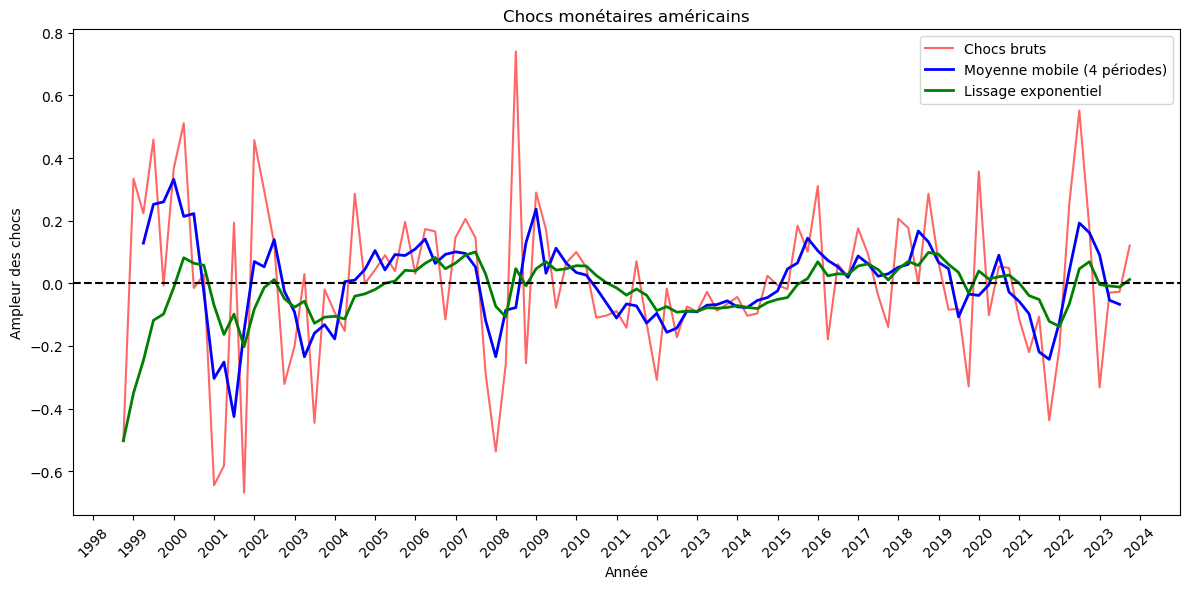

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 p√©riodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks'].ewm(span=10, adjust=False).mean()

# Tracer les s√©ries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 p√©riodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Ann√©e')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs mon√©taires am√©ricains')
plt.legend()

# üëâ Personnaliser l'axe des X pour afficher une ann√©e tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affich√© : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks.png", dpi=300)
plt.show()

### 3√®me essai: avec 1 lag

In [9]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1',
                   'inflation','inflation_lag1',
                   'GDPC1_log', 'GDPC1_lag1_log', 
                   'spread corporate','spread corporate_lag1', 
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks_1lag'] = model.resid

# Ajouter les √©toiles de significativit√©
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les r√©sultats format√©s
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les √©toiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# R√©organiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au d√©but
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_1_lags.tex", "w") as f:
    f.write(latex_table)

# Afficher le r√©sum√© de la r√©gression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     354.5
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           1.24e-65
Time:                        07:51:25   Log-Likelihood:                -39.292
No. Observations:                 101   AIC:                             96.58
Df Residuals:                      92   BIC:                             120.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.14

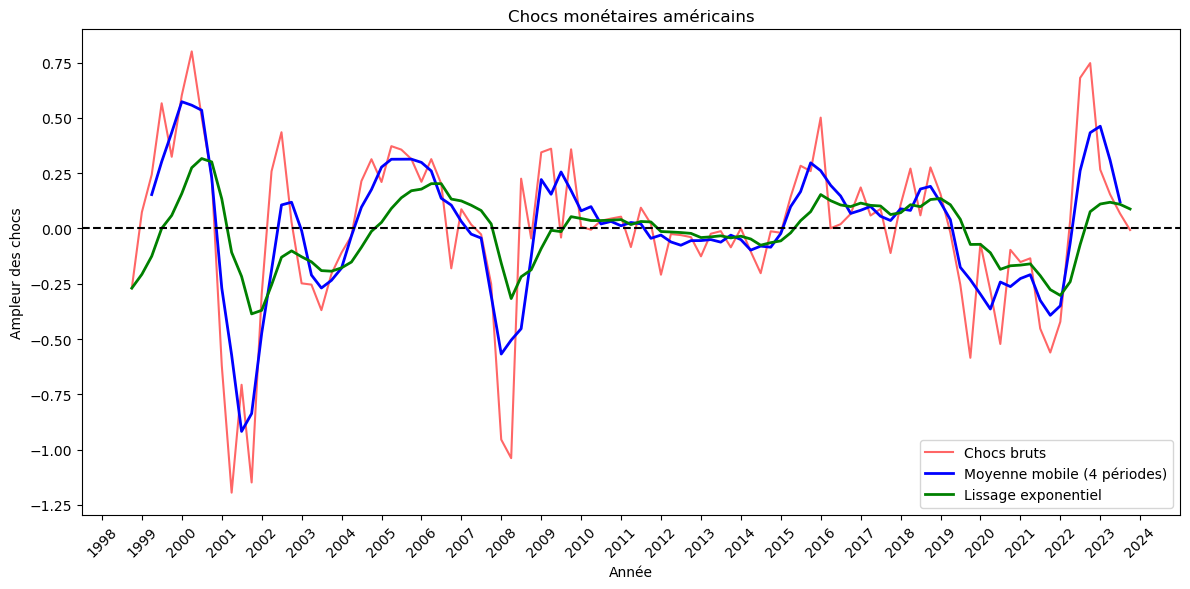

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 p√©riodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks_1lag'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks_1lag'].ewm(span=10, adjust=False).mean()

# Tracer les s√©ries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_1lag'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 p√©riodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Ann√©e')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs mon√©taires am√©ricains')
plt.legend()

# üëâ Personnaliser l'axe des X pour afficher une ann√©e tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affich√© : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks_1lag.png", dpi=300)
plt.show()

### 4√® essai: mod√®le sans les corporate spreads, avec 2 lags

In [14]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   'inflation','inflation_lag1','inflation_lag2', 
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks_2lags_v2'] = model.resid

# Ajouter les √©toiles de significativit√©
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les r√©sultats format√©s
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les √©toiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# R√©organiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au d√©but
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags_v2.tex", "w") as f:
    f.write(latex_table)

# Afficher le r√©sum√© de la r√©gression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     570.7
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           5.50e-76
Time:                        07:51:50   Log-Likelihood:                -9.4795
No. Observations:                 101   AIC:                             38.96
Df Residuals:                      91   BIC:                             65.11
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.1924      7.836  

TypeError: float() argument must be a string or a real number, not 'Period'

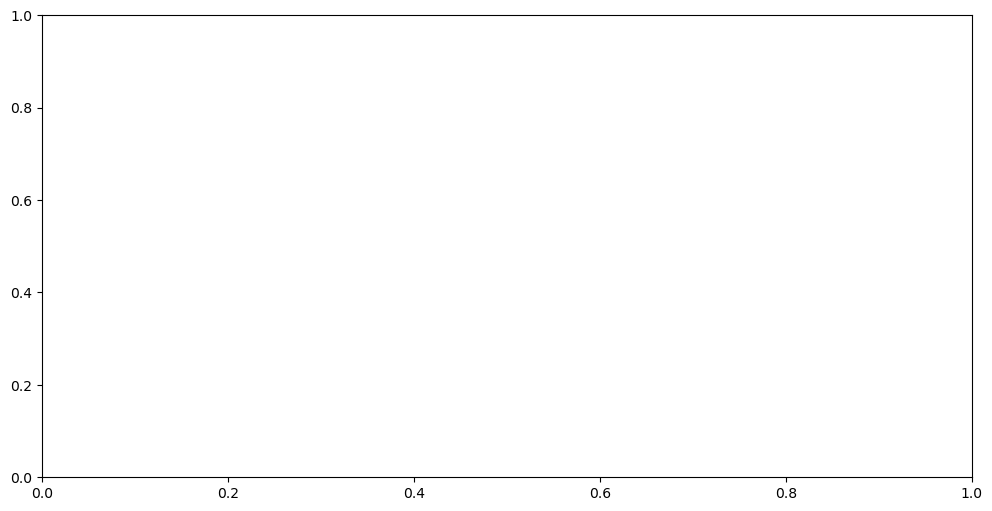

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#data_US_clean.index = data_US_clean.index.to_timestamp()


# Appliquer une moyenne glissante sur 6 p√©riodes (ajuster selon les besoins)
data_US_clean['monetary_shocks_smooth'] = data_US_clean['monetary_shocks_2lags_v2'].rolling(window=4, center=True).mean()
data_US_clean['monetary_shocks_ewma'] = data_US_clean['monetary_shocks_2lags_v2'].ewm(span=10, adjust=False).mean()

# Tracer les s√©ries
plt.figure(figsize=(12, 6))
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_2lags_v2'], color='red', alpha=0.6, label='Chocs bruts')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_smooth'], color='blue', linewidth=2, label='Moyenne mobile (4 p√©riodes)')
plt.plot(data_US_clean.index, data_US_clean['monetary_shocks_ewma'], color='green', linewidth=2, label='Lissage exponentiel')
plt.axhline(0, linestyle="--", color="black")
plt.xlabel('Ann√©e')
plt.ylabel('Ampleur des chocs')
plt.title('Chocs mon√©taires am√©ricains')
plt.legend()

# üëâ Personnaliser l'axe des X pour afficher une ann√©e tous les ans
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Ticks tous les ans
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format affich√© : 2020, 2021, etc.
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("monetary_shocks_2lags_v2.png", dpi=300)
plt.show()

### 5√®me essai: sans l'inflation, avec 2 lags

In [16]:
import pandas as pd
import statsmodels.api as sm

# Supprimer les lignes avec NaN ou Inf
data_US_clean = data_US.dropna()
data_US_clean = data_US_clean.apply(pd.to_numeric, errors='coerce')

# D√©finition de Y (variable d√©pendante)
Y = data_US_clean['Policy rate']

# S√©lectionner toutes les colonnes explicatives
X = data_US_clean[['Policy rate_lag1','Policy rate_lag2',
                   
                   'GDPC1_log', 'GDPC1_lag1_log', 'GDPC1_lag2_log', 
                   'spread corporate','spread corporate_lag1', 'spread corporate_lag2',
                   'time_squared']]

# Ajouter une constante
X = sm.add_constant(X)

# R√©gression
model = sm.OLS(Y, X).fit()

# Extraire les r√©sidus comme chocs mon√©taires
data_US_clean['monetary_shocks_2lags_v3'] = model.resid

# Ajouter les √©toiles de significativit√©
def significance_stars(p):
    if p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.10:
        return '*'
    else:
        return ''

# Construire un DataFrame avec les r√©sultats format√©s
coef_table = pd.DataFrame({
    "Coefficient": model.params,
    "Std. Error": model.bse,
    "t-Statistic": model.tvalues,
    "P-Value": model.pvalues
})

# Ajouter les √©toiles aux coefficients
coef_table["Significance"] = coef_table["P-Value"].apply(significance_stars)
coef_table["Coefficient"] = coef_table["Coefficient"].round(4).astype(str) + coef_table["Significance"]

# R√©organiser les colonnes pour l'affichage
coef_table = coef_table[["Coefficient", "Std. Error", "t-Statistic", "P-Value"]]

# Renommer les colonnes en ajoutant le format LaTeX pour du texte en gras
coef_table.columns = [r"\textbf{Coefficient}", r"\textbf{Std. Error}", r"\textbf{t-Statistic}", r"\textbf{P-Value}"]

# Ajouter les statistiques globales en haut de la table
stats_dict = {
    r"\textbf{R-squared}": round(model.rsquared, 4),
    r"\textbf{Adj. R-squared}": round(model.rsquared_adj, 4),
    r"\textbf{F-statistic}": round(model.fvalue, 4),
    r"\textbf{Prob (F-statistic)}": round(model.f_pvalue, 4),
    r"\textbf{Observations}": int(model.nobs)
}

# Convertir en DataFrame et transposer pour affichage
stats_table = pd.DataFrame.from_dict(stats_dict, orient='index', columns=["Value"]).T

# Convertir en LaTeX avec statistiques au d√©but
latex_table = stats_table.to_latex(index=False, escape=False) + "\n" + coef_table.to_latex(index=True, escape=False)

# Sauvegarder en fichier .tex
with open("regression_results_2_lags_v3.tex", "w") as f:
    f.write(latex_table)

# Afficher le r√©sum√© de la r√©gression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Policy rate   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     576.0
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           3.63e-76
Time:                        07:51:52   Log-Likelihood:                -9.0186
No. Observations:                 101   AIC:                             38.04
Df Residuals:                      91   BIC:                             64.19
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.26

## 2√®me partie du mod√®le: impact des chocs mon√©taires

Nous allons maintenant estimer avec une r√©gression de panel l'impact des chocs de politique mon√©taire identifi√©s, sur diff√©rentes variables (GDP, employment ? ...). La m√©thode utilis√© est celle de Jorda (2005), la m√©thode de projection locale. Cela consiste √† "estimer des projections locales √† chaque p√©riode au lieu d'extrapoler sur des horizons lointains √† partir d'un mod√®le."
Nous allons estimer une √©quation de la forme suivante, comme dans Iacoviello & Navarro (2018) :

$$
y_{i,t+h} = \alpha_{i,h} + \beta_h u_t + A_{h,i} Z_{i,t} + \varepsilon_{i,t+h}
$$

o√π :

- $y_{i,t+h}$ est le PIB du pays $ i $ au temps $t$,
- $\alpha_{i,h} $ est un effet fixe sp√©cifique au pays,
- $u_t$ est le choc mon√©taire,
- $Z_{i,t}$  repr√©sente les variables de contr√¥le : 4 lags du PIB, des tendances lin√©aire et quadratique,
- $\varepsilon_{i,t+h}$  est le terme d'erreur.

Pour chaque h il faut estimer un $\beta_h$, ensuite il faut faire les IRF (fonctions de r√©ponse impulsionnelle) pour les diff√©rents Y qu'on utilise.


Pour les variables de contr√¥le, il faut s√ªrement tester lesquelles sont les meilleures, ne pas forc√©ment reproduire exactement le mod√®le.

On a des donn√©es trimestrielles donc on prend h de 0 √† 4 ou 8

In [51]:
import pandas as pd
data=pd.read_excel("../Donn√©es_produites/base_de_donn√©es_v1.xlsx")

In [52]:
# üîç √âtape 1 : V√©rification des colonnes
print("Colonnes initiales :", data.columns.tolist())

# Identifier automatiquement la colonne temporelle si nomm√©e "Unnamed: 0" ou similaire
time_col_candidates = [col for col in data.columns if "unnamed" in col.lower() or "time" in col.lower()]
if time_col_candidates:
    time_col = time_col_candidates[0]
    data = data.rename(columns={time_col: "Time"})
else:
    raise ValueError("Impossible de trouver la colonne 'Time' dans le fichier Excel.")

# üîÅ √âtape 2 : Conversion au format long
df_long = data.melt(id_vars="Time", var_name="Variable_Country", value_name="Value")

# üîç √âtape 3 : V√©rification du format des noms
# Affiche quelques exemples pour s‚Äôassurer du format attendu
print("\nExemples de noms de colonnes fusionn√©es :", df_long["Variable_Country"].unique()[:5])

# Appliquer un split seulement si un underscore est pr√©sent
split_ok = df_long["Variable_Country"].str.contains("_")
df_valid = df_long[split_ok].copy()

# S√©parer en deux colonnes : Variable + Country
df_valid[["Variable", "Country"]] = df_valid["Variable_Country"].str.rsplit("_", n=1, expand=True)

# ‚ö†Ô∏è Facultatif : alerter sur les noms qui n'ont pas pu √™tre s√©par√©s
if not split_ok.all():
    print("Colonnes ignor√©es car mal nomm√©es :", df_long.loc[~split_ok, "Variable_Country"].unique())

# R√©organiser les colonnes
df_final = df_valid[["Time", "Country", "Variable", "Value"]]

# ‚úÖ Affichage final
print("\nAper√ßu du DataFrame long format :")
print(df_final.head())

# Sauvegarde dans data pour compatibilit√© avec le reste de ton notebook
data = df_final.copy()


Colonnes initiales : ['Unnamed: 0', 'CPI_Austria', 'PIB_Austria', 'LT_IR_Austria', 'ST_IR_Austria', 'WH_Austria', 'P_Growth_Austria', 'CPI_Belgium', 'PIB_Belgium', 'LT_IR_Belgium', 'ST_IR_Belgium', 'WH_Belgium', 'P_Growth_Belgium', 'CPI_Bulgaria', 'PIB_Bulgaria', 'LT_IR_Bulgaria', 'ST_IR_Bulgaria', 'WH_Bulgaria', 'P_Growth_Bulgaria', 'CPI_Czechia', 'PIB_Czechia', 'LT_IR_Czechia', 'ST_IR_Czechia', 'WH_Czechia', 'P_Growth_Czechia', 'CPI_Denmark', 'PIB_Denmark', 'LT_IR_Denmark', 'ST_IR_Denmark', 'WH_Denmark', 'P_Growth_Denmark', 'CPI_Estonia', 'PIB_Estonia', 'LT_IR_Estonia', 'ST_IR_Estonia', 'WH_Estonia', 'P_Growth_Estonia', 'CPI_Finland', 'PIB_Finland', 'LT_IR_Finland', 'ST_IR_Finland', 'WH_Finland', 'P_Growth_Finland', 'CPI_France', 'PIB_France', 'LT_IR_France', 'ST_IR_France', 'WH_France', 'P_Growth_France', 'CPI_Germany', 'PIB_Germany', 'LT_IR_Germany', 'ST_IR_Germany', 'WH_Germany', 'P_Growth_Germany', 'CPI_Greece', 'PIB_Greece', 'LT_IR_Greece', 'ST_IR_Greece', 'WH_Greece', 'P_Growth

In [61]:
#data
#df_target

R√©ponse PIB am√©ricain √† choc mon√©taire

R√©ponses des taux obligataires/corpo aux chocs

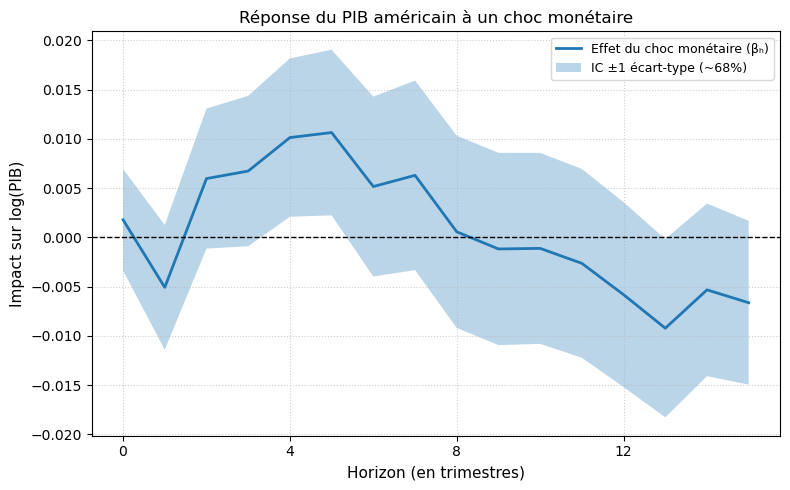

In [40]:
# ==============================
# 1) Param√®tres et initialisation
# ==============================
H = 15  # nombre maximal d'horizons
betas = []
stderr_list = []

# ==============================
# 2) Boucle sur les horizons h = 0 √† H
# ==============================
for h in range(H + 1):
    # Copie du DataFrame pour chaque horizon (pour √©viter des colonnes temporaires cumul√©es)
    df = data_US_clean.copy()

    # a) Cr√©ation des lags du PIB
    for lag in range(1, 5):
        df[f'GDP_lag{lag}'] = df['GDPC1_log'].shift(lag)

    # b) Ajout d'une tendance lin√©aire et quadratique
    df['trend'] = range(len(df))
    df['trend_sq'] = df['trend'] ** 2

    # c) Variable d√©pendante : PIB √† l‚Äôhorizon h (d√©calage de -h)
    df[f'GDP_lead_{h}'] = df['GDPC1_log'].shift(-h)

    # d) Nettoyage des lignes NaN (pour √©viter de perdre l'√©quation)
    df_model = df.dropna(subset=[
        f'GDP_lead_{h}',        # la variable d√©pendante (PIB d√©cal√©)
        'monetary_shocks_2lags_v3',
        'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4'
    ])

    # e) Variable d√©pendante et explicatives
    Y = df_model[f'GDP_lead_{h}']
    X = df_model[['monetary_shocks_2lags_v3', 
                  'GDP_lag1', 'GDP_lag2', 'GDP_lag3', 'GDP_lag4',
                  'trend', 'trend_sq']]
    X = sm.add_constant(X)

    # f) Estimation de la r√©gression OLS pour l‚Äôhorizon h
    model = sm.OLS(Y, X).fit()

    # g) Extraction du coefficient du choc et de son √©cart-type
    beta_h = model.params['monetary_shocks_2lags_v3']
    stderr_h = model.bse['monetary_shocks_2lags_v3']

    # h) Stockage
    betas.append(beta_h)
    stderr_list.append(stderr_h)

# ======================================
# 3) Calcul d'un intervalle de confiance (IC 68%)
#    (Pour 1 √©cart-type, ‚âà 68% si distribution normale)
# ======================================
lower = [b - s for b, s in zip(betas, stderr_list)]
upper = [b + s for b, s in zip(betas, stderr_list)]

# ======================================
# 4) Trac√© de la Fonction de R√©ponse (IRF)
# ======================================
horizons = range(H + 1)

plt.figure(figsize=(8, 5))

# Courbe principale : coefficient Œ≤·µ£
plt.plot(horizons, betas, linewidth=2, label="Effet du choc mon√©taire (Œ≤‚Çï)")

# Intervalle de confiance
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ¬±1 √©cart-type (~68%)")

# Ligne horizontale √† 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Mise en forme
plt.title("R√©ponse du PIB am√©ricain √† un choc mon√©taire", fontsize=12)
plt.xlabel("Horizon (en trimestres)", fontsize=11)
plt.ylabel("Impact sur log(PIB)", fontsize=11)
plt.xticks(np.arange(0, H+1, step=4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.show()


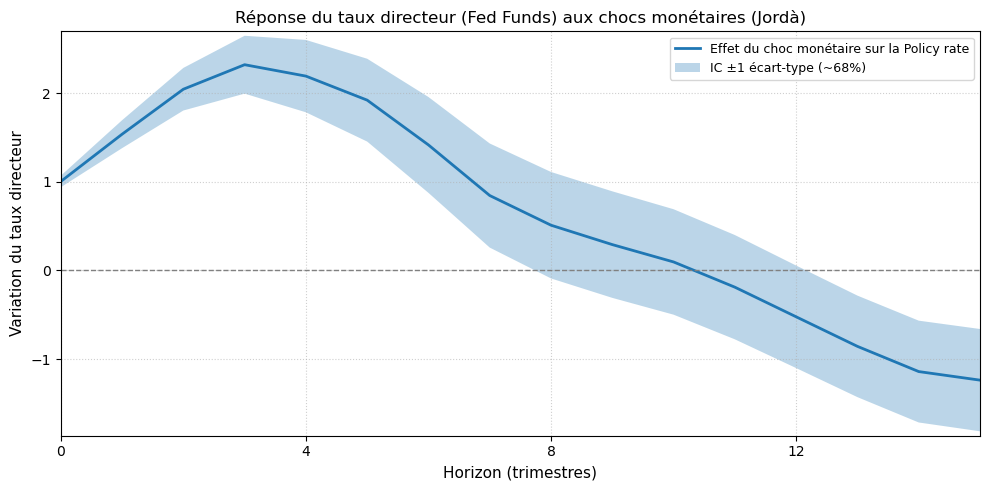

In [41]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ===============================
# 1) Param√®tres de la projection
# ===============================
H = 15  # horizon maximal (en trimestres)
betas = []
stderr_list = []

# ===============================
# 2) Boucle sur les horizons h
# ===============================
for h in range(H + 1):
    # Copie pour √©viter d'empiler les colonnes d'un tour √† l'autre
    df = data_US_clean.copy()

    # ------------------------------
    # a) Cr√©ation des lags du taux directeur
    # ------------------------------
    for lag in range(1, 5):
        df[f'rate_lag{lag}'] = df['Policy rate'].shift(lag)

    # ------------------------------
    # b) Tendance lin√©aire + quadratique (contr√¥le)
    # ------------------------------
    df['trend'] = range(len(df))
    df['trend_sq'] = df['trend'] ** 2

    # ------------------------------
    # c) Variable d√©pendante : taux √† l'horizon h
    #    => Policy rate au temps t+h
    # ------------------------------
    df[f'rate_lead_{h}'] = df['Policy rate'].shift(-h)

    # ------------------------------
    # d) Sous-√©chantillon sans NaN
    # ------------------------------
    df_model = df.dropna(subset=[
        f'rate_lead_{h}',      # la variable d√©pendante
        'monetary_shocks_2lags_v3',  # votre choc mon√©taire
        'rate_lag1', 'rate_lag2', 'rate_lag3', 'rate_lag4'
    ])

    # ------------------------------
    # e) Construction de Y et X
    # ------------------------------
    Y = df_model[f'rate_lead_{h}']  # le Policy rate √† horizon h
    X = df_model[['monetary_shocks_2lags_v3',
                  'rate_lag1', 'rate_lag2', 'rate_lag3', 'rate_lag4',
                  'trend', 'trend_sq']]

    X = sm.add_constant(X)

    # ------------------------------
    # f) Estimation OLS
    # ------------------------------
    model = sm.OLS(Y, X).fit()

    # ------------------------------
    # g) R√©cup√©ration du coefficient + √©cart-type
    # ------------------------------
    beta = model.params['monetary_shocks_2lags_v3']
    stderr = model.bse['monetary_shocks_2lags_v3']

    betas.append(beta)
    stderr_list.append(stderr)

# ==============================================
# 3) Construction d'un Intervalle de Confiance (IC)
#    On prend +/- 1 √©cart-type (approximatif 68%)
# ==============================================
lower = [b - s for b, s in zip(betas, stderr_list)]
upper = [b + s for b, s in zip(betas, stderr_list)]

# ==============================================
# 4) Trac√© de la "r√©ponse impulsionnelle" (Local Projections)
# ==============================================
horizons = range(H + 1)
y_min = min(lower) - 0.05
y_max = max(upper) + 0.05

plt.figure(figsize=(10, 5))

# Courbe principale : coefficients Œ≤‚Çï
plt.plot(horizons, betas, linewidth=2, label="Effet du choc mon√©taire sur la Policy rate")

# IC 68%
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ¬±1 √©cart-type (~68%)")

# Ligne horizontale = 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Param√®tres du graphique
plt.title("R√©ponse du taux directeur (Fed Funds) aux chocs mon√©taires (Jord√†)", fontsize=12)
plt.xlabel("Horizon (trimestres)", fontsize=11)
plt.ylabel("Variation du taux directeur", fontsize=11)

plt.ylim(y_min, y_max)
plt.xlim(0, H)
plt.xticks(np.arange(0, H+1, 4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(loc="best", fontsize=9)
plt.tight_layout()
plt.show()


R√©ponse des PIBs des pays europ√©ens aux chocs

In [50]:
categories = {
    "√âconomie en d√©veloppement": [
        "Czechia", "Lithuania", "Latvia", "Poland", "Bulgaria", "Slovakia",
        "Hungary", "Slovenia", "Iceland", "Estonia", "Romania"
    ],
    "Grosse √©conomie d√©velopp√©e": [
        "Germany", "United Kingdom", "France", "Italy", "Spain", "Netherlands"
    ],
    "Petite √©conomie d√©velopp√©e": [
        "Austria", "Belgium", "Denmark", "Greece", "Finland", "Ireland",
        "Luxembourg", "Norway", "Portugal", "Sweden", "Switzerland"
    ]
}


üìã R√©sultats par pays :
        Country                    Category  Coef_monetary_shock   P_value  \
11      Iceland   √âconomie en d√©veloppement             0.080649  0.040776   
21      Romania   √âconomie en d√©veloppement             0.056283  0.123946   
2      Bulgaria   √âconomie en d√©veloppement             0.039675  0.076889   
5       Estonia   √âconomie en d√©veloppement             0.035209  0.096247   
3       Czechia   √âconomie en d√©veloppement             0.034825  0.111755   
15    Lithuania   √âconomie en d√©veloppement             0.024100  0.362740   
4       Denmark  Petite √©conomie d√©velopp√©e             0.023436  0.025903   
14       Latvia   √âconomie en d√©veloppement             0.023427  0.460839   
22     Slovakia   √âconomie en d√©veloppement             0.019561  0.304462   
0       Austria  Petite √©conomie d√©velopp√©e             0.017005  0.164427   
20     Portugal  Petite √©conomie d√©velopp√©e             0.015876  0.260590   
19       Po

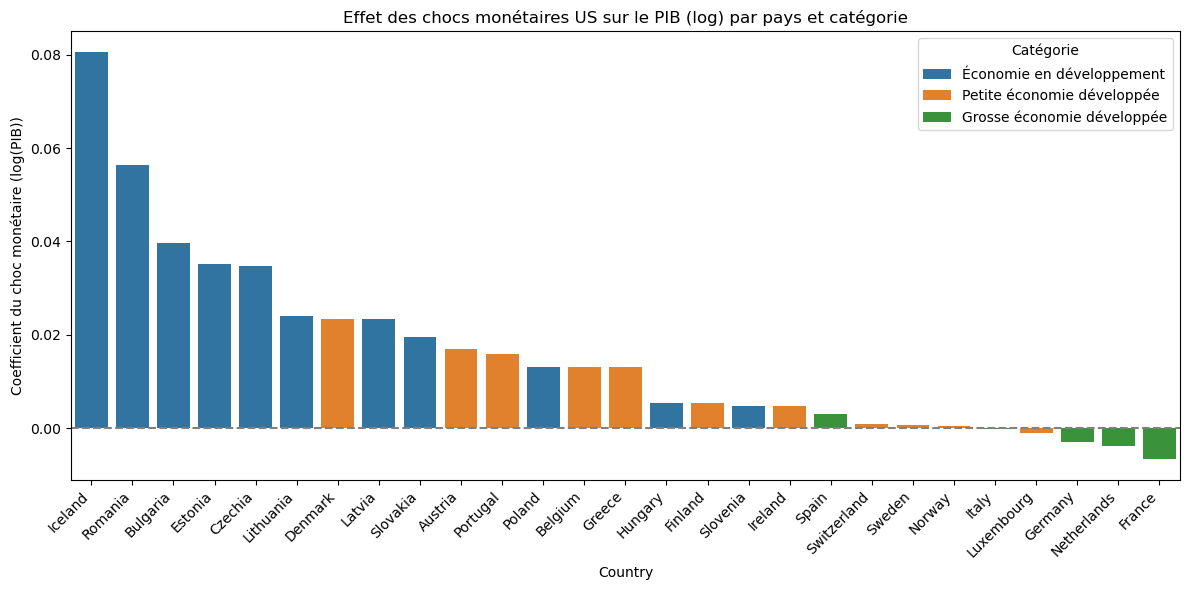

In [47]:
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

# --- 2. Filtrer les donn√©es sur le PIB et prendre le log ---
target_variable = "PIB"
df_target = data[data["Variable"] == target_variable].copy()
df_target = df_target[df_target["Value"] > 0]  # s√©curit√© pour log
df_target["Value"] = np.log(df_target["Value"])

# --- 3. Trier et ajouter lags + tendances ---
df_target = df_target.sort_values(["Country", "Time"])

for lag in range(1, 5):
    df_target[f"lag{lag}"] = df_target.groupby("Country")["Value"].shift(lag)

df_target["trend"] = df_target.groupby("Country").cumcount() + 1
df_target["trend_sq"] = df_target["trend"] ** 2
df_target["Category"] = df_target["Country"].apply(get_category)

# --- 4. R√©gressions pays par pays ---
results = []
required_cols = ["Value", "monetary_shocks_2lags_v3", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]

for country in df_target["Country"].unique():
    sub = df_target[df_target["Country"] == country].dropna(subset=required_cols)

    if len(sub) < 10:
        continue

    X = sub[["monetary_shocks_2lags_v3", "lag1", "lag2", "lag3", "lag4", "trend", "trend_sq"]]
    X = sm.add_constant(X)
    y = sub["Value"]

    model = sm.OLS(y, X).fit()
    coef = model.params["monetary_shocks_2lags_v3"]
    pval = model.pvalues["monetary_shocks_2lags_v3"]
    category = get_category(country)

    results.append({
        "Country": country,
        "Category": category,
        "Coef_monetary_shock": coef,
        "P_value": pval,
        "R_squared": model.rsquared
    })

# --- 5. R√©sultats ---
results_df = pd.DataFrame(results).sort_values("Coef_monetary_shock", ascending=False)

print("\nüìã R√©sultats par pays :")
print(results_df)

# --- 6. Graphique group√© par cat√©gorie ---
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="Country", y="Coef_monetary_shock", hue="Category", dodge=False)
plt.axhline(0, color="gray", linestyle="--")
plt.title("Effet des chocs mon√©taires US sur le PIB (log) par pays et cat√©gorie")
plt.ylabel("Coefficient du choc mon√©taire (log(PIB))")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cat√©gorie")
plt.tight_layout()
plt.show()

IRF des pays europ√©ens

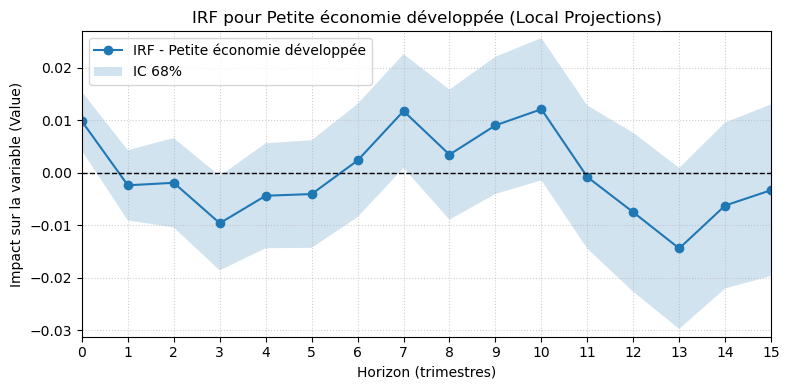

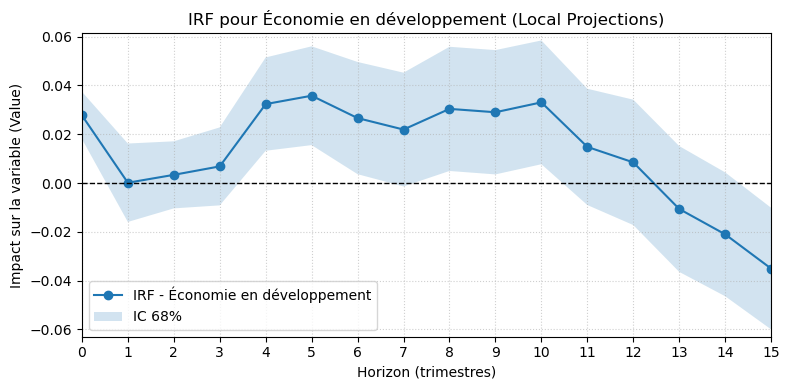

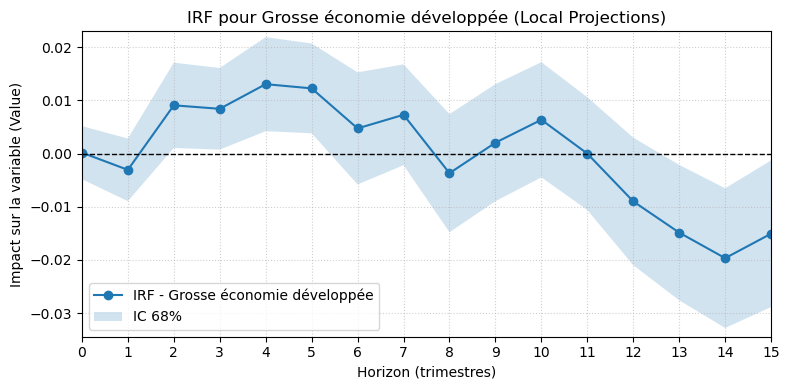

In [49]:
# ===================================
# 1) Param√®tres
# ===================================
horizons = range(16)  # de 0 √† 15
# df_target : votre DataFrame contenant d√©j√†
#  - "Value"         = la variable d'int√©r√™t (ex: log(PIB) ou autre)
#  - "Category"      = la cat√©gorie (classement que vous utilisez)
#  - "Country"       = le pays
#  - "monetary_shocks_2lags_v3" = votre choc mon√©taire US
#  - un index temporel ou au moins un ordre temporel implicite

# On cr√©e des structures pour stocker les IRFs par cat√©gorie :
results_irf_cat = {cat: [] for cat in df_target["Category"].unique()}
conf_ints_cat = {cat: [] for cat in df_target["Category"].unique()}

# ===================================
# 2) Estimation des IRF par cat√©gorie et par horizon
# ===================================
for h in horizons:
    # -----------------------------------
    # a) On cr√©e un DataFrame temporaire
    #    avec la variable d√©pendante "lead h"
    # -----------------------------------
    df_shifted = df_target.copy()

    # Pour chaque pays, on d√©cale Value de -h
    df_shifted[f"lead_{h}"] = df_shifted.groupby("Country")["Value"].shift(-h)

    # On cr√©e les lags 1 √† 4 de la variable Value
    for lag in range(1, 5):
        df_shifted[f"lag{lag}"] = df_shifted.groupby("Country")["Value"].shift(lag)

    # Tendance lin√©aire + quadratique (par pays)
    df_shifted["trend"] = df_shifted.groupby("Country").cumcount() + 1
    df_shifted["trend_sq"] = df_shifted["trend"] ** 2

    # -----------------------------------
    # b) Pour chaque cat√©gorie, on estime la r√©gression:
    #    lead_{h} = alpha + beta_h * Shock_t + sum_{p=1}^4 gamma_p * lag p + ...
    # -----------------------------------
    for cat in results_irf_cat.keys():
        # Filtrer la cat√©gorie
        sub = df_shifted[df_shifted["Category"] == cat].dropna(
            subset=[
                f"lead_{h}",
                "monetary_shocks_2lags_v3",
                "lag1", "lag2", "lag3", "lag4",
                "trend", "trend_sq"
            ]
        )

        # S'il y a trop peu d'observations, on saute
        if len(sub) < 10:
            results_irf_cat[cat].append(np.nan)
            conf_ints_cat[cat].append((np.nan, np.nan))
            continue

        # Variables d√©pendante / explicatives
        Y = sub[f"lead_{h}"]
        X = sub[[
            "monetary_shocks_2lags_v3",
            "lag1", "lag2", "lag3", "lag4",
            "trend", "trend_sq"
        ]]
        X = sm.add_constant(X)

        # R√©gression OLS (avec erreurs st. robustes type HC1)
        model = sm.OLS(Y, X).fit(cov_type='HC1')

        # Extraction du coefficient du choc + son √©cart-type
        beta = model.params["monetary_shocks_2lags_v3"]
        stderr = model.bse["monetary_shocks_2lags_v3"]

        # Stockage de la valeur ponctuelle et de l'IC (68% ‚âà ¬±1 √©cart-type)
        results_irf_cat[cat].append(beta)
        conf_ints_cat[cat].append((beta - stderr, beta + stderr))

# ===================================
# 3) Affichage des IRFs cat√©gorie par cat√©gorie
# ===================================
for cat in results_irf_cat:
    irf = results_irf_cat[cat]         # la suite des betas pour h = 0..15
    ci = np.array(conf_ints_cat[cat])  # la suite des IC

    # V√©rifie s‚Äôil n‚Äôy a que des NaN (pas assez de donn√©es)
    if all(np.isnan(irf)):
        print(f"‚è≠Ô∏è  Pas assez de donn√©es pour {cat}")
        continue

    lower, upper = ci[:, 0], ci[:, 1]

    # D√©finir des bornes dynamiques, en √©vitant le cas all-NaN
    valid_lower = lower[~np.isnan(lower)]
    valid_upper = upper[~np.isnan(upper)]
    if len(valid_lower) == 0 or len(valid_upper) == 0:
        print(f"‚è≠Ô∏è  Pas assez de donn√©es valides pour {cat}")
        continue

    y_min = valid_lower.min() - 0.05*abs(valid_lower.min())
    y_max = valid_upper.max() + 0.05*abs(valid_upper.max())

    # Trac√© de l'IRF
    plt.figure(figsize=(8, 4))
    plt.plot(horizons, irf, marker='o', label=f"IRF - {cat}")
    plt.fill_between(horizons, lower, upper, alpha=0.2, label="IC 68%")
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    plt.title(f"IRF pour {cat} (Local Projections)")
    plt.xlabel("Horizon (trimestres)")
    plt.ylabel("Impact sur la variable (Value)")
    plt.ylim(y_min, y_max)
    plt.xlim(0, max(horizons))
    plt.xticks(horizons)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


Regression panel pour IRF PIB √©trangers

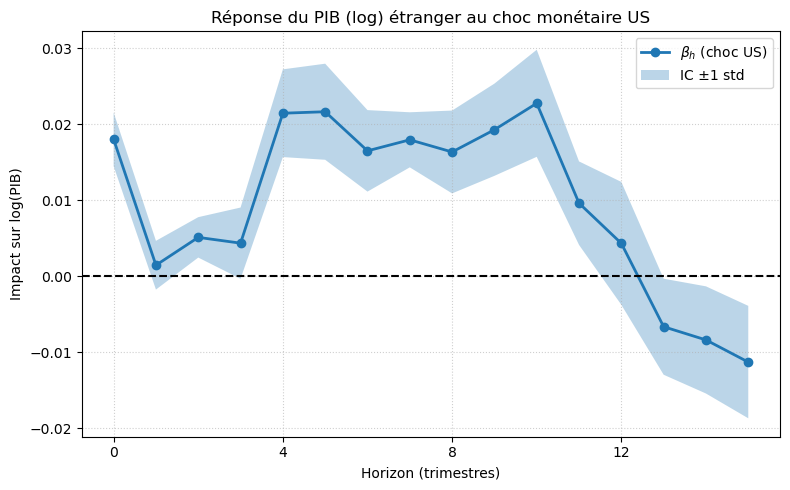

In [120]:
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 0) Pr√©parer les chocs mon√©taires US
# ------------------------------------------------
df_shocks = data_US_clean.reset_index()[["date", "monetary_shocks_2lags_v3"]].copy()
df_shocks = df_shocks.rename(columns={"date": "Time", "monetary_shocks_2lags_v3": "shock_US"})

# Convertir Time en datetime avec p√©riode trimestrielle correcte
df_shocks["Time"] = pd.PeriodIndex(df_shocks["Time"], freq="Q").to_timestamp()

# ------------------------------------------------
# 1) Corriger le format de data["Time"] ‚Üí datetime trimestriel
# Nettoie et convertit "1995-Q1" ‚Üí "1995Q1" ‚Üí datetime
data["Time"] = data["Time"].astype(str).str.replace("-", "")
data["Time"] = pd.PeriodIndex(data["Time"], freq="Q").to_timestamp()


# ------------------------------------------------
# 2) Fusion avec les chocs
# ------------------------------------------------
df_merged = pd.merge(data, df_shocks, on="Time", how="inner")

# ------------------------------------------------
# 3) Filtrer le PIB (log)
# ------------------------------------------------
df_pib = df_merged[df_merged["Variable"] == "PIB"].copy()
df_pib = df_pib[df_pib["Value"] > 0]
df_pib["Value"] = np.log(df_pib["Value"])

# ------------------------------------------------
# 4) Panel index + s√©curit√© Time
# ------------------------------------------------
df_pib = df_pib.sort_values(["Country", "Time"]).copy()
df_pib["Time"] = pd.to_datetime(df_pib["Time"])  # s√©curit√© explicite
df_pib = df_pib.set_index(["Country", "Time"])

# ------------------------------------------------
# 5) Projections locales fa√ßon Jord√†
# ------------------------------------------------
H = 15
betas = []
stderr = []

for h in range(H + 1):
    df_lp = df_pib.copy()
    df_lp[f"y_lead{h}"] = df_lp.groupby(level="Country")["Value"].shift(-h)

    for lag in range(1, 5):
        df_lp[f"y_lag{lag}"] = df_lp.groupby(level="Country")["Value"].shift(lag)

    df_lp = df_lp.reset_index()
    df_lp["trend"] = df_lp.groupby("Country").cumcount() + 1
    df_lp["trend_sq"] = df_lp["trend"] ** 2
    df_lp = df_lp.set_index(["Country", "Time"])

    needed = [f"y_lead{h}", "shock_US"] + [f"y_lag{k}" for k in range(1, 5)]
    df_model = df_lp.dropna(subset=needed).copy()

    Y = df_model[f"y_lead{h}"]
    X_cols = ["shock_US", "y_lag1", "y_lag2", "y_lag3", "y_lag4", "trend", "trend_sq"]
    df_model["const"] = 1.0
    X_cols = ["const"] + X_cols

    model = PanelOLS(dependent=Y, exog=df_model[X_cols], entity_effects=True)
    res = model.fit(cov_type="clustered", cluster_entity=True)

    betas.append(res.params["shock_US"])
    stderr.append(res.std_errors["shock_US"])

# ------------------------------------------------
# 6) Trac√© de l'IRF
# ------------------------------------------------
betas = np.array(betas)
stderr = np.array(stderr)
lower = betas - stderr
upper = betas + stderr

horizons = range(H + 1)
plt.figure(figsize=(8, 5))
plt.plot(horizons, betas, marker='o', linewidth=2, label=r"$\beta_h$ (choc US)")
plt.fill_between(horizons, lower, upper, alpha=0.3, label="IC ¬±1 std")
plt.axhline(0, color='black', linestyle='--')
plt.title("R√©ponse du PIB (log) √©tranger au choc mon√©taire US", fontsize=12)
plt.xlabel("Horizon (trimestres)")
plt.ylabel("Impact sur log(PIB)")
plt.xticks(np.arange(0, H + 1, 4))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


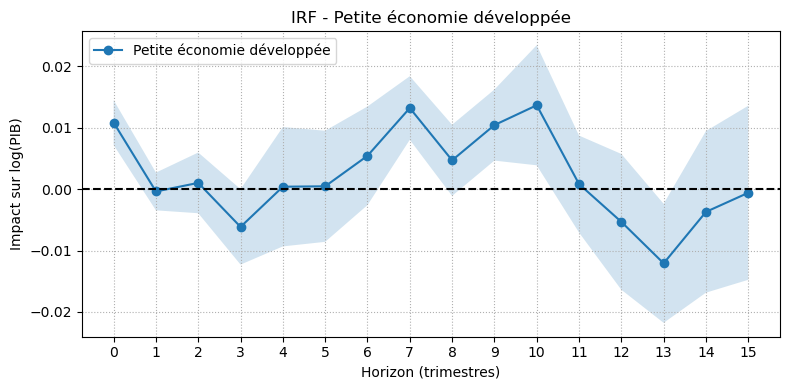

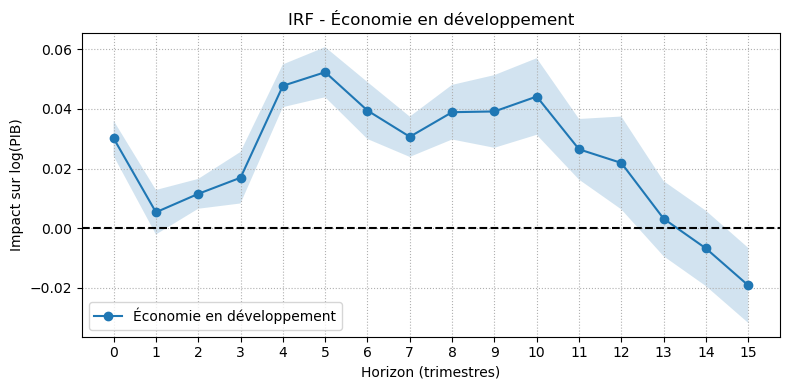

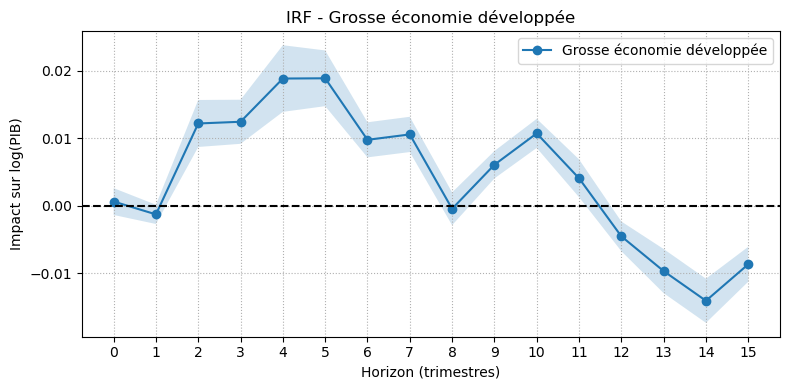

In [121]:
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Chocs mon√©taires US
df_shocks = data_US_clean.reset_index()[["date", "monetary_shocks_2lags_v3"]].copy()
df_shocks.columns = ["Time", "shock_US"]
df_shocks["Time"] = pd.PeriodIndex(df_shocks["Time"], freq="Q").to_timestamp()

# 2. Panel principal (data)
data["Time"] = pd.PeriodIndex(data["Time"].astype(str), freq="Q").to_timestamp()

# 3. Fusion
df_merged = pd.merge(data, df_shocks, on="Time", how="inner")

# 4. Filtrer sur le PIB + log
df_pib = df_merged[df_merged["Variable"] == "PIB"].copy()
df_pib = df_pib[df_pib["Value"] > 0]
df_pib["Value"] = np.log(df_pib["Value"])

# 5. Attribution des cat√©gories
def get_category(country):
    for cat, countries in categories.items():
        if country in countries:
            return cat
    return "Autre"

df_pib["Category"] = df_pib["Country"].apply(get_category)

# 6. Projections locales par cat√©gorie
H = 15
results = {}
for cat in df_pib["Category"].unique():
    betas, stderr = [], []
    df_cat = df_pib[df_pib["Category"] == cat].copy()
    df_cat = df_cat.sort_values(["Country", "Time"])
    df_cat = df_cat.set_index(["Country", "Time"])

    for h in range(H + 1):
        df_lp = df_cat.copy()
        df_lp[f"y_lead{h}"] = df_lp.groupby(level="Country")["Value"].shift(-h)
        for lag in range(1, 5):
            df_lp[f"y_lag{lag}"] = df_lp.groupby(level="Country")["Value"].shift(lag)

        df_lp = df_lp.reset_index()
        df_lp["trend"] = df_lp.groupby("Country").cumcount() + 1
        df_lp["trend_sq"] = df_lp["trend"] ** 2
        df_lp = df_lp.set_index(["Country", "Time"])

        needed = [f"y_lead{h}", "shock_US"] + [f"y_lag{k}" for k in range(1, 5)]
        df_model = df_lp.dropna(subset=needed).copy()
        if df_model.empty:
            betas.append(np.nan)
            stderr.append(np.nan)
            continue

        Y = df_model[f"y_lead{h}"]
        X_cols = ["shock_US", "y_lag1", "y_lag2", "y_lag3", "y_lag4", "trend", "trend_sq"]
        df_model["const"] = 1.0
        X = df_model[["const"] + X_cols]

        model = PanelOLS(dependent=Y, exog=X, entity_effects=True)
        res = model.fit(cov_type="clustered", cluster_entity=True)

        betas.append(res.params["shock_US"])
        stderr.append(res.std_errors["shock_US"])

    results[cat] = {
        "beta": np.array(betas),
        "stderr": np.array(stderr)
    }

# 7. Trac√© IRF pour chaque cat√©gorie
horizons = range(H + 1)
for cat, res_cat in results.items():
    beta, se = res_cat["beta"], res_cat["stderr"]
    lower, upper = beta - se, beta + se

    plt.figure(figsize=(8, 4))
    plt.plot(horizons, beta, marker='o', label=cat)
    plt.fill_between(horizons, lower, upper, alpha=0.2)
    plt.axhline(0, color='black', linestyle='--')
    plt.title(f"IRF - {cat}")
    plt.xlabel("Horizon (trimestres)")
    plt.ylabel("Impact sur log(PIB)")
    plt.grid(True, linestyle=':')
    plt.xticks(horizons)
    plt.legend()
    plt.tight_layout()
    plt.show()
